In [17]:
# Standard Library Imports (if any)

# Third-party Library Imports
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects

# Local Module Imports
from utils import *
from new_data_handling import DataManager
from plot import *
from new_data_handling.data_processor import *

In [18]:
major = COUNTRIES.MAJOR
offshore = COUNTRIES.OFFSHORE
sample = major + offshore

major = COUNTRIES.MAJOR
offshore = COUNTRIES.OFFSHORE
sample = major + offshore
period = (2001, 2004)
save = None
interpolate = False
dm = DataManager(
    raw_dir = "../data/raw",
    save_dir = "../data/clean"
)
ds_full = dm.get_dataset("ds")
fed_full = dm.get_dataset("fed")

# Access datasets
cpis = dm.cpis.get_data(period=period)
ds = dm.ds.get_data(period=period)
fed = dm.fed.get_data(period=period)
wb = dm.wb.get_data(period=period)
wfe = dm.wfe.get_data(period=period)
gdp = dm.gdp.get_data(period=period)

In [19]:
# Index returns
period = (2001, 2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
panel_dates = fed.columns
returns_index = compute_index_excess_returns(ds, fed, major)

# Weights
period = (2001, 2004)
cpis = dm.cpis.get_data(period=period)
wb = dm.wb.get_data(countries=major, period=period)
weights_per_year = compute_weights(cpis, wb, major, offshore)
weights_avg = weights_per_year.mean(axis=1).unstack()
weights_avg["MX"] = weights_per_year.loc["MX"][[2003,2004]].mean(axis=1)

In [20]:
weights_per_year.loc["AT"]

,2001,2002,2003,2004
Counterpart Country,,,,
AR,0.000090,0.000068,0.000081,0.000203
AT,0.387230,0.476494,0.495842,0.523136
BE,0.008348,0.006991,0.004864,0.008044
BR,0.001265,0.001062,0.002638,0.002694
CA,0.003932,0.003347,0.003576,0.004385
CH,0.035941,0.029689,0.028996,0.025560
CL,0.000188,0.000145,0.000097,0.000100
CO,0.000009,0.000123,0.000006,0.000049
CZ,0.001361,0.001131,0.001566,0.002188


In [21]:
means = pd.DataFrame(index=major)
vars = pd.DataFrame(index=major)
covs = pd.DataFrame(index=major)

for year, weights in weights_per_year.items():
    weights = weights.unstack()
    returns = compute_excess_returns_statistics(returns_index, weights)
    means[year] = returns["mean_portfolio"]
    vars[year] = returns["var_portfolio"]  
    covs[year] = returns["cov_index_portfolio"]

returns = compute_excess_returns_statistics(returns_index, weights_avg)
means_avg = returns["mean_portfolio"]
vars_avg = returns["var_portfolio"]  
covs_avg = returns["cov_index_portfolio"]

print((means.var(axis=1) / (vars_avg / 48)))
print((means.var(axis=1) / (vars_avg / 48)).mean())
print((means.var(axis=1) / (vars_avg / 48)).max())

AR    1.865311e-04
AT    1.605402e-01
BE    6.819023e-03
BR    1.097465e-04
CA    3.716603e-03
CH    5.542862e-04
CL    1.983686e-03
CO    1.395859e-03
CZ    6.756995e-02
DE    1.215038e-03
DK    2.450672e-03
ES    7.877030e-04
FI    3.411305e-05
FR    5.456232e-05
GB    1.910208e-03
GR    8.303982e-05
HK    1.579449e-04
HU    1.177262e-03
ID    7.831336e-06
IL    1.331844e-05
IT    2.672837e-04
JP    6.648873e-04
KR    1.427618e-04
MX    6.026181e-04
MY    7.058614e-06
NL    2.235391e-03
NO    5.646739e-03
PH    2.090760e-06
PL    3.393813e-05
PT    6.472946e-04
RU    7.535829e-05
SE    1.961867e-03
SG    1.994913e-03
TH    3.266947e-05
TR    8.172903e-07
US    1.143938e-02
VE    9.691155e-06
ZA    5.957013e-03
dtype: float64
0.007433930207476636
0.16054020244288447


0.21498801990132646
0.0033863533733550608
143


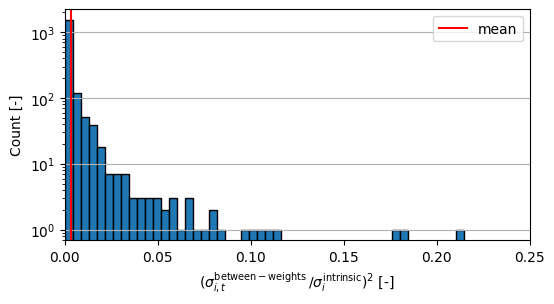

In [22]:
dir = os.path.abspath("../output/exp1/figures/")

returns = pd.DataFrame()
for year, weights in weights_per_year.items():
    weights = weights.unstack()
    returns[year] = (returns_index.T @ weights).stack()

returns_avg = (returns_index.T @ weights_avg)
var_intrinsic = returns_avg.var(axis=0)
var_between_weights = returns.var(axis=1).unstack()
ratios = var_between_weights/var_intrinsic
print(ratios.max().max())
print(ratios.mean().mean())
print((ratios>0.01).sum().sum())
range_10 = np.array([1,2,3,4,5,6,7,8,9])
plt.figure(figsize=(6,3))
ratios.stack().hist(bins=50, log=True, edgecolor="black")
plt.axvline(ratios.mean().mean(), color="red", label="mean")
plt.grid(axis='x', visible=False)
plt.ylabel("Count [-]")
plt.xlabel(r"$(\sigma^\mathrm{between-weights}_{i,t} \/ / \sigma^\mathrm{intrinsic}_{i})^2$ [-]")
plt.legend()
plt.xlim([0,0.25])
plt.savefig(dir+"/weights_justification.pdf", bbox_inches="tight")
plt.show()
copy_files()

In [26]:
(ratios>0.1).sum()

Counterpart Country
AR    0
AT    3
BE    0
BR    0
CA    0
CH    0
CL    0
CO    0
CZ    0
DE    0
DK    0
ES    0
FI    0
FR    0
GB    0
GR    0
HK    0
HU    0
ID    0
IL    0
IT    0
JP    0
KR    0
MX    0
MY    0
NL    4
NO    0
PH    0
PL    0
PT    0
RU    0
SE    0
SG    0
TH    0
TR    0
US    0
VE    0
ZA    0
dtype: int64